## Libraries & data loading

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import pickle

df_2015 = pd.read_csv('../data/2015.csv')
df_2016 = pd.read_csv('../data/2016.csv')
df_2017 = pd.read_csv('../data/2017.csv')
df_2018 = pd.read_csv('../data/2018.csv')
df_2019 = pd.read_csv('../data/2019.csv')


## Cleaning process

In [16]:
def standardize_columns(df, year):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'\W', '')
    if year in [2015, 2016]:
        df.rename(columns={
            'economy_(gdp_per_capita)': 'gdp_per_capita',
            'health_(life_expectancy)': 'healthy_life_expectancy',
            'trust_(government_corruption)': 'perceptions_of_corruption'
        }, inplace=True)
    if year == 2017:
        df.rename(columns={
            'happiness.rank': 'happiness_rank',
            'happiness.score': 'happiness_score',
            'economy..gdp.per.capita.': 'gdp_per_capita',
            'health..life.expectancy.': 'healthy_life_expectancy',
            'trust..government.corruption.': 'perceptions_of_corruption'
        }, inplace=True)
    if year in [2018, 2019]:
        df.rename(columns={
            'country_or_region': 'country',
            'score': 'happiness_score',
            'overall_rank': 'happiness_rank'
        }, inplace=True)
    return df

dfs = [df_2015, df_2016, df_2017, df_2018, df_2019]
years = [2015, 2016, 2017, 2018, 2019]
dfs = [standardize_columns(df, year) for df, year in zip(dfs, years)]


In [17]:
all_data = pd.concat(dfs, keys=years, names=['year'])
all_data.reset_index(level=1, drop=True, inplace=True)
all_data.reset_index(inplace=True)

numeric_cols = all_data.select_dtypes(include=[np.number]).columns
non_numeric_cols = all_data.select_dtypes(exclude=[np.number]).columns

all_data[numeric_cols] = all_data[numeric_cols].fillna(all_data[numeric_cols].mean())
all_data[non_numeric_cols] = all_data[non_numeric_cols].fillna(all_data[non_numeric_cols].mode().iloc[0])

all_data.dropna(inplace=True)

In [18]:
all_data['gdp_health_interaction'] = all_data['gdp_per_capita'] * all_data['healthy_life_expectancy']

all_data['log_gdp_per_capita'] = np.log1p(all_data['gdp_per_capita'])
all_data['log_social_support'] = np.log1p(all_data['social_support'])

## Data analysis

              year  happiness_rank  happiness_score  standard_error  \
count   782.000000      782.000000       782.000000      782.000000   
mean   2016.993606       78.698210         5.379018        0.047885   
std       1.417364       45.182384         1.127456        0.007688   
min    2015.000000        1.000000         2.693000        0.018480   
25%    2016.000000       40.000000         4.509750        0.047885   
50%    2017.000000       79.000000         5.322000        0.047885   
75%    2018.000000      118.000000         6.189500        0.047885   
max    2019.000000      158.000000         7.769000        0.136930   

       gdp_per_capita      family  healthy_life_expectancy     freedom  \
count      782.000000  782.000000               782.000000  782.000000   
mean         0.916047    0.990347                 0.612416    0.402828   
std          0.407340    0.246975                 0.248309    0.116515   
min          0.000000    0.000000                 0.000000    0.

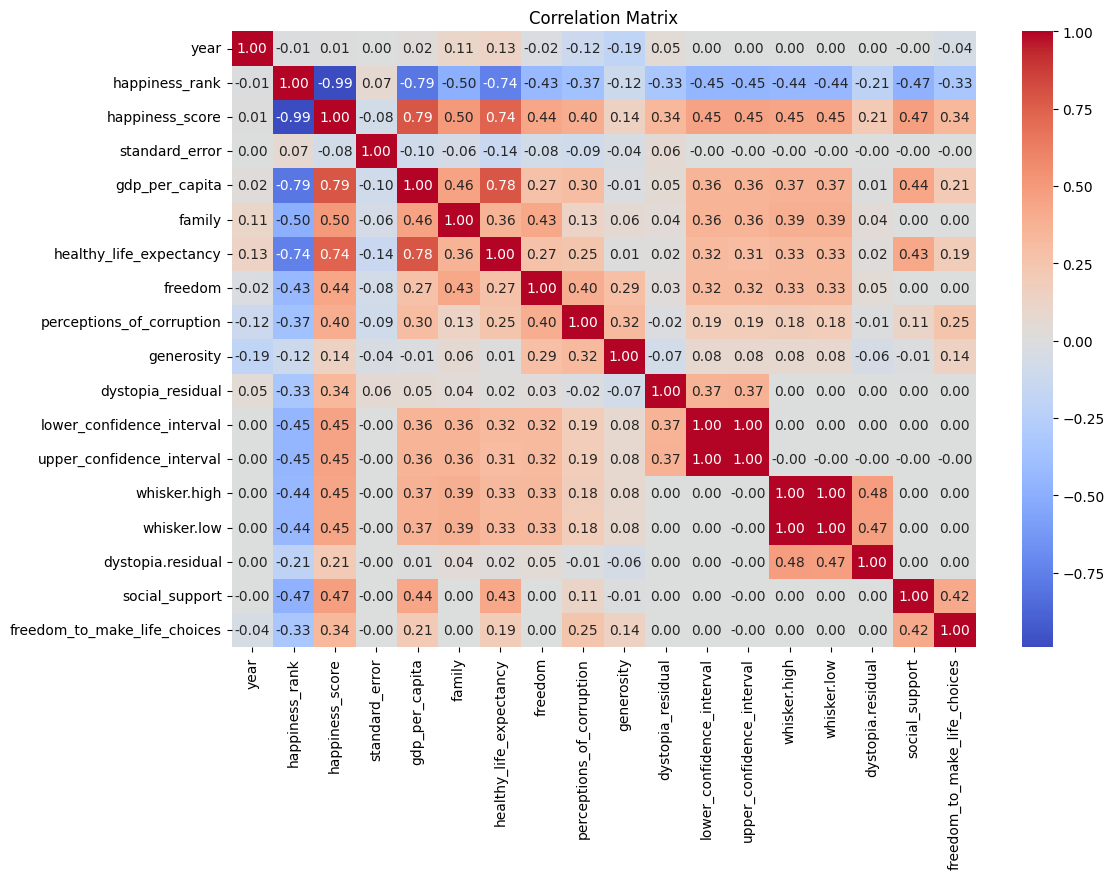

In [19]:
print(all_data.describe())

plt.figure(figsize=(12, 8))
sns.heatmap(all_data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [20]:
#features = ['log_gdp_per_capita', 'log_social_support', 'healthy_life_expectancy', 
#           'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption', 'gdp_health_interaction']
features = ['log_gdp_per_capita', 'log_social_support', 'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption', 'gdp_health_interaction']
target = 'happiness_score'

X = all_data[features]
y = all_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [21]:
# Prediction case #1: Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Polynomial Features - Mean Squared Error: {mse}")
print(f"Polynomial Features - R^2 Score: {r2}")

Polynomial Features - Mean Squared Error: 0.32471802472942013
Polynomial Features - R^2 Score: 0.7484799653866189


In [22]:
# Prediction case #2: Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest - Mean Squared Error: {mse}")
print(f"Random Forest - R^2 Score: {r2}")

Random Forest - Mean Squared Error: 0.2706934794858266
Random Forest - R^2 Score: 0.7903262888266669


In [23]:
# Prediction case #3: Ridge Regression for Regularization
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Ridge Regression - Mean Squared Error: {mse}")
print(f"Ridge Regression - R^2 Score: {r2}")

Ridge Regression - Mean Squared Error: 0.362724635227172
Ridge Regression - R^2 Score: 0.719040811228492


In [24]:
# Prediction case #4: XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost - Mean Squared Error: {mse}")
print(f"XGBoost - R^2 Score: {r2}")

XGBoost - Mean Squared Error: 0.29346856821957984
XGBoost - R^2 Score: 0.7726851643112976


In [25]:
# Prediction case #5: Stacking Regressor
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Stacking Regressor - Mean Squared Error: {mse}")
print(f"Stacking Regressor - R^2 Score: {r2}")

Stacking Regressor - Mean Squared Error: 0.26137725175147697
Stacking Regressor - R^2 Score: 0.7975424509850881


In [26]:
best_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
best_model.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_p...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression())

In [27]:
path = '../models/best_model.pkl'

with open(path, 'wb') as model_file:
    pickle.dump(best_model, model_file)
